# Gradient Boosting From Scratch

Let's implement gradient boosting from scratch.

In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from tensorflow.keras.datasets import boston_housing

np.random.seed(0)

plt.rcParams['figure.figsize'] = (8.0, 5.0)
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14

In [2]:
(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

In [3]:
x_train.shape

(404, 13)

## Exploration

Let explore the data before building a model. The goal is to predict the median value of owner-occupied homes in $1000s.


In [4]:
# Create training/test dataframes for visualization/data exploration.
# Description of features: https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD','TAX', 'PTRATIO', 'B', 'LSTAT']
df_train = pd.DataFrame(x_train, columns=feature_names)
df_test = pd.DataFrame(x_test, columns=feature_names)

In [5]:
df_train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,1.23247,0.0,8.14,0.0,0.538,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72
1,0.02177,82.5,2.03,0.0,0.415,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11
2,4.89822,0.0,18.10,0.0,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26
3,0.03961,0.0,5.19,0.0,0.515,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01
4,3.69311,0.0,18.10,0.0,0.713,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65


In [6]:
df_train.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.745111,11.480198,11.104431,0.061881,0.557356,6.267082,69.010644,3.740271,9.440594,405.898515,18.475990,354.783168,12.740817
std,9.240734,23.767711,6.811308,0.241238,0.117293,0.709788,27.940665,2.030215,8.698360,166.374543,2.200382,94.111148,7.254545
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,188.000000,12.600000,0.320000,1.730000
25%,0.081437,0.000000,5.130000,0.000000,0.453000,5.874750,45.475000,2.077100,4.000000,279.000000,17.225000,374.672500,6.890000
50%,0.268880,0.000000,9.690000,0.000000,0.538000,6.198500,78.500000,3.142300,5.000000,330.000000,19.100000,391.250000,11.395000
75%,3.674808,12.500000,18.100000,0.000000,0.631000,6.609000,94.100000,5.118000,24.000000,666.000000,20.200000,396.157500,17.092500
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.725000,100.000000,10.710300,24.000000,711.000000,22.000000,396.900000,37.970000


Exercise #1: What are the most predictive features? Determine correlation for each feature with the label. You may find the [corr](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) function useful.

In [7]:
# check for highly correlated features
df_train.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
CRIM,1.000000,-0.192179,0.397419,-0.050828,0.405765,-0.217597,0.344410,-0.378590,0.609689,0.575652,0.273447,-0.390613,0.434384
ZN,-0.192179,1.000000,-0.533823,-0.041981,-0.521713,0.338683,-0.578728,0.650787,-0.311091,-0.303522,-0.403139,0.176006,-0.415237
INDUS,0.397419,-0.533823,1.000000,0.052839,0.774200,-0.409924,0.656350,-0.725155,0.599226,0.701362,0.379284,-0.372885,0.603129
CHAS,-0.050828,-0.041981,0.052839,1.000000,0.079803,0.040431,0.080488,-0.083101,-0.024851,-0.051343,-0.122008,0.037832,-0.011017
NOX,0.405765,-0.521713,0.774200,0.079803,1.000000,-0.335866,0.729338,-0.777062,0.616535,0.673471,0.188160,-0.409479,0.592994
RM,-0.217597,0.338683,-0.409924,0.040431,-0.335866,1.000000,-0.240875,0.233970,-0.243990,-0.307904,-0.367256,0.145525,-0.610844
AGE,0.344410,-0.578728,0.656350,0.080488,0.729338,-0.240875,1.000000,-0.766670,0.462188,0.512746,0.282193,-0.278403,0.590898
DIS,-0.378590,0.650787,-0.725155,-0.083101,-0.777062,0.233970,-0.766670,1.000000,-0.511179,-0.543668,-0.243067,0.295995,-0.507075
RAD,0.609689,-0.311091,0.599226,-0.024851,0.616535,-0.243990,0.462188,-0.511179,1.000000,0.922676,0.449908,-0.478245,0.490250
TAX,0.575652,-0.303522,0.701362,-0.051343,0.673471,-0.307904,0.512746,-0.543668,0.922676,1.000000,0.440499,-0.471777,0.534752


In [8]:
for col in feature_names:
    print("%s: %s" % (col, df_train[col].corr(pd.Series(y_train))))

CRIM: -0.37849762384495783
ZN: 0.38029882789427116
INDUS: -0.4767431574341945
CHAS: 0.16866050054188647
NOX: -0.4383282777729245
RM: 0.6814825193146462
AGE: -0.36417297878336435
DIS: 0.25390039671311576
RAD: -0.3755149970536418
TAX: -0.4487366956390774
PTRATIO: -0.49398959605640913
B: 0.3439533705058262
LSTAT: -0.7307927632282041


## Train Gradient Boosting model

Training Steps to build model an ensemble of $K$ estimators.
1. At $k=0$ build base model ,  $\hat{y}_{0}$: $\hat{y}_{0}=base\_predicted$
3. Compute residuals $r = \sum_{i=0}^n (y_{k,i} - \hat{y}_{k,i})$; $n: number\ train\ examples$
4. Train new model, fitting on residuals, $r$. We will call the predictions from this model $e_{k}\_predicted$
5. Update model predictions at step $k$ by adding residual to current predictions: $\hat{y}_{k} = \hat{y}_{k-1} + e_{k}\_predicted$
6. Repeat steps 2 - 5 `K` times.

In summary, the goal is to build K estimators that learn to predict the residuals from the prior model; thus we are learning to "correct" the
predictions up until this point.
<br>

$\hat{y}_{K} = base\_predicted\ +\ \sum_{j=1}^Ke_{j}\_predicted$

### Build base model

Exercise #2: Make an initial prediction using the `BaseModel` class -- configure the `predict` method to predict the training mean.

In [9]:
class BaseModel(object):
    """Initial model that predicts mean of train set."""

    def __init__(self, y_train):
        self.train_mean = np.mean(y_train)

    def predict(self, x):
        """Return train mean for every prediction."""
        means = [self.train_mean for xx in x] 
        return means

def compute_residuals(label, pred):
    """Compute difference of labels and predictions.

    When using mean squared error loss function, the residual indicates the 
    negative gradient of the loss function in prediction space. Thus by fitting
    the residuals, we performing gradient descent in prediction space. See for
    more detail:

    https://explained.ai/gradient-boosting/L2-loss.html
    """
    return label - pred

def compute_rmse(x):
    return np.sqrt(np.mean(np.square(x)))

In [10]:
# Build a base model that predicts the mean of the training set.
base_model = BaseModel(y_train)
test_pred = base_model.predict(x_test)
test_residuals = compute_residuals(y_test, test_pred)
compute_rmse(test_residuals)

9.149363873885578

Let's see how the base model performs on out test data. Let's visualize performance compared to the `LSTAT` feature.

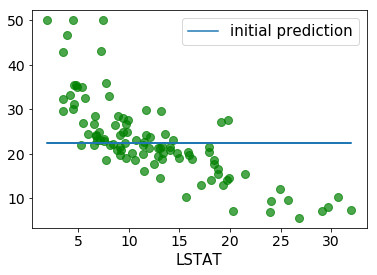

In [11]:
feature = df_test.LSTAT

# Pick a predictive feature for plotting.
plt.plot(feature, y_test, 'go', alpha=0.7, markersize=8)
plt.plot(feature, test_pred, label='initial prediction')

plt.xlabel('LSTAT', size=15)
plt.legend(prop={'size': 15});

There is definitely room for improvement. We can also look at the residuals:

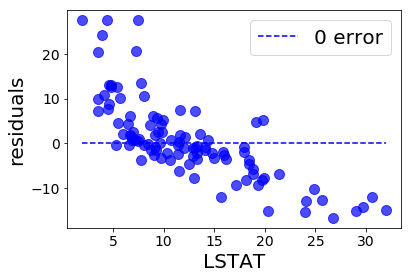

In [12]:
plt.plot(feature, test_residuals, 'bo', alpha=0.7, markersize=8)
plt.ylabel('residuals', size=15)
plt.xlabel('LSTAT', size=15)
plt.plot([feature.min(), feature.max()], [0, 0], 'b--', label='0 error');
plt.legend(prop={'size': 15});

### Train Boosting model

Returning back to boosting, let's use our very first base model as are initial prediction. We'll then perform subsequent boosting iterations to improve upon this model.

create_weak_model

In [13]:
def create_weak_learner(**tree_params):
    """Initialize a Decision Tree model."""
    model = DecisionTreeRegressor(**tree_params)
    return model

Make initial prediction.

Exercise #3: Update the prediction on the training set (`train_pred`) and on the testing set (`test_pred`) using the weak learner that predicts the residuals.

In [14]:
base_model = BaseModel(y_train)

In [15]:
# Training parameters. 
tree_params = {
    'max_depth': 1,
    'criterion': 'mse',
    'random_state': 123
  }
N_ESTIMATORS = 50
BOOSTING_LR = 0.1

# Initial prediction, residuals.
train_pred = base_model.predict(x_train)
test_pred = base_model.predict(x_test)
train_residuals = compute_residuals(y_train, train_pred)
test_residuals = compute_residuals(y_test, test_pred)

feat_importances = np.zeros(len(feature_names))

# Boosting.
train_rmse, test_rmse = [], []
for _ in range(0, N_ESTIMATORS):
    train_rmse.append(compute_rmse(train_residuals))
    test_rmse.append(compute_rmse(test_residuals))
    # Train weak learner.
    model = create_weak_learner(**tree_params)
    model.fit(x_train, train_residuals)
    
    iter_imps = model.feature_importances_   
    feat_importances = feat_importances + iter_imps
    
    # Boosting magic happens here: add the residual prediction to correct
    # the prior model.
    
    grad_approx = model.predict(x_train)
    train_pred += grad_approx * BOOSTING_LR
    train_residuals = compute_residuals(y_train, train_pred)  
    
    # Keep track of residuals on validation set.
    grad_approx = model.predict(x_test)
    test_pred += grad_approx * BOOSTING_LR
    test_residuals = compute_residuals(y_test, test_pred)
    
feat_importances /= N_ESTIMATORS    

## Interpret results

Can you improve the model results?

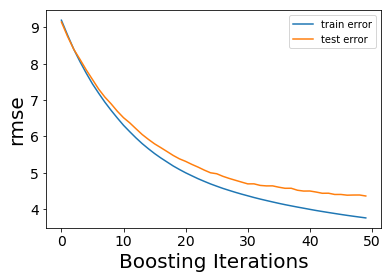

In [16]:
plt.figure()
plt.plot(train_rmse, label='train error')
plt.plot(test_rmse, label='test error')
plt.ylabel('rmse', size=20)
plt.xlabel('Boosting Iterations', size=20);
plt.legend()

In [17]:
print("Final test RMSE: %s" % test_rmse[-1])

Final test RMSE: 4.35925085219514


In [18]:
list(zip(feature_names, feat_importances))

[('CRIM', 0.1),
 ('ZN', 0.0),
 ('INDUS', 0.0),
 ('CHAS', 0.02),
 ('NOX', 0.08),
 ('RM', 0.3),
 ('AGE', 0.0),
 ('DIS', 0.14),
 ('RAD', 0.0),
 ('TAX', 0.0),
 ('PTRATIO', 0.02),
 ('B', 0.0),
 ('LSTAT', 0.34)]

## Let's visualize how the performance changes across iterations

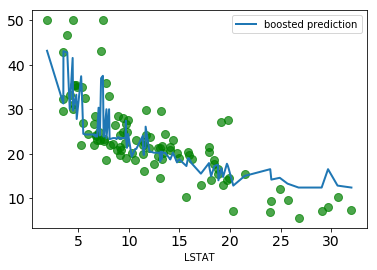

In [19]:
feature = df_test.LSTAT
ix = np.argsort(feature)

# Pick a predictive feature for plotting.
plt.plot(feature, y_test, 'go', alpha=0.7, markersize=8)
plt.plot(feature[ix], test_pred[ix], label='boosted prediction', linewidth=2)

plt.xlabel('LSTAT', size=10)
plt.legend(prop={'size': 10});

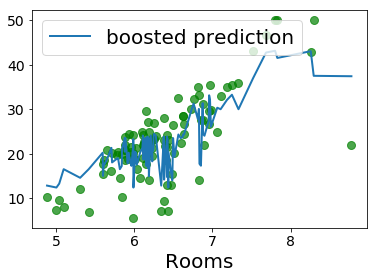

In [20]:
feature = df_test.RM
ix = np.argsort(feature)

# Pick a predictive feature for plotting.
plt.plot(feature, y_test, 'go', alpha=0.7, markersize=8)
plt.plot(feature[ix], test_pred[ix], label='boosted prediction', linewidth=2)

plt.xlabel('Rooms', size=15)
plt.legend(prop={'size': 15});

In [21]:
# Training parameters. 
tree_params = {
    'max_depth': 3,
    'criterion': 'mse',
    'random_state': 123
  }
N_ESTIMATORS = 50
BOOSTING_LR = 0.1

# Initial prediction, residuals.
train_pred = base_model.predict(x_train)
test_pred = base_model.predict(x_test)
train_residuals = compute_residuals(y_train, train_pred)
test_residuals = compute_residuals(y_test, test_pred)
feat_importances = np.zeros(len(feature_names))
# Boosting.
train_rmse, test_rmse = [], []
for _ in range(0, N_ESTIMATORS):
    train_rmse.append(compute_rmse(train_residuals))
    test_rmse.append(compute_rmse(test_residuals))
    # Train weak learner.
    model = create_weak_learner(**tree_params)
    model.fit(x_train, train_residuals)
    # Boosting magic happens here: add the residual prediction to correct
    # the prior model.
    grad_approx = model.predict(x_train)
    train_pred += grad_approx * BOOSTING_LR
    train_residuals = compute_residuals(y_train, train_pred)  
    
    iter_imps = model.feature_importances_   
    feat_importances = feat_importances + iter_imps
    
    # Keep track of residuals on validation set.
    grad_approx = model.predict(x_test)
    test_pred += grad_approx * BOOSTING_LR
    test_residuals = compute_residuals(y_test, test_pred)
    
feat_importances /= N_ESTIMATORS    

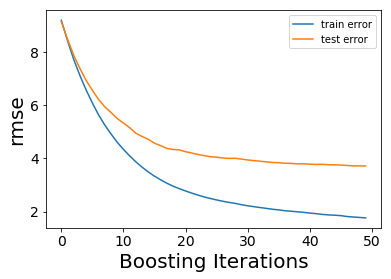

In [22]:
plt.figure()
plt.plot(train_rmse, label='train error')
plt.plot(test_rmse, label='test error')
plt.ylabel('rmse', size=20)
plt.xlabel('Boosting Iterations', size=20);
plt.legend()

In [23]:
print("Final test RMSE: %s" % test_rmse[-1])

Final test RMSE: 3.717799672009396


In [24]:
list(zip(feature_names, feat_importances))

[('CRIM', 0.07233113057900821),
 ('ZN', 0.0),
 ('INDUS', 0.004656173441873258),
 ('CHAS', 0.0065125132778102515),
 ('NOX', 0.04609574514871394),
 ('RM', 0.2348456474236902),
 ('AGE', 0.059055274683618),
 ('DIS', 0.15634035639200142),
 ('RAD', 0.014337124867598122),
 ('TAX', 0.060811629701084016),
 ('PTRATIO', 0.07070852527896326),
 ('B', 0.03215710170011392),
 ('LSTAT', 0.24214877750552546)]

We are beginning to overfit - train and test curves diverge significantly. Try depth of 2

In [25]:
# Training parameters. 
tree_params = {
    'max_depth': 2,
    'criterion': 'mse',
    'random_state': 123
  }
N_ESTIMATORS = 50
BOOSTING_LR = 0.1

# Initial prediction, residuals.
train_pred = base_model.predict(x_train)
test_pred = base_model.predict(x_test)
train_residuals = compute_residuals(y_train, train_pred)
test_residuals = compute_residuals(y_test, test_pred)
feat_importances = np.zeros(len(feature_names))

# Boosting.
train_rmse, test_rmse = [], []
for _ in range(0, N_ESTIMATORS):
    train_rmse.append(compute_rmse(train_residuals))
    test_rmse.append(compute_rmse(test_residuals))
    # Train weak learner.
    model = create_weak_learner(**tree_params)
    model.fit(x_train, train_residuals)
    # Boosting magic happens here: add the residual prediction to correct
    # the prior model.
    grad_approx = model.predict(x_train)
    train_pred += grad_approx * BOOSTING_LR
    train_residuals = compute_residuals(y_train, train_pred)
    
    iter_imps = model.feature_importances_   
    feat_importances = feat_importances + iter_imps
    
    # Keep track of residuals on validation set.
    grad_approx = model.predict(x_test)
    test_pred += grad_approx * BOOSTING_LR
    test_residuals = compute_residuals(y_test, test_pred) 
    
feat_importances /= N_ESTIMATORS    

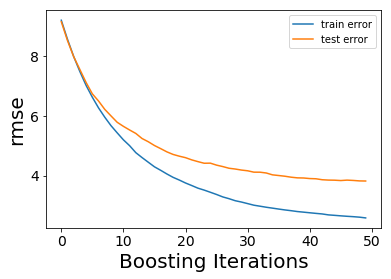

In [26]:
plt.figure()
plt.plot(train_rmse, label='train error')
plt.plot(test_rmse, label='test error')
plt.ylabel('rmse', size=20)
plt.xlabel('Boosting Iterations', size=20);
plt.legend()

In [27]:
print("Final test RMSE: %s" % test_rmse[-1])

Final test RMSE: 3.818029000855561


In [28]:
list(zip(feature_names, feat_importances))

[('CRIM', 0.07706721796956663),
 ('ZN', 0.0),
 ('INDUS', 0.0),
 ('CHAS', 0.023894641235059758),
 ('NOX', 0.0814230010696406),
 ('RM', 0.2577146775459957),
 ('AGE', 0.0016683197544475118),
 ('DIS', 0.16198265437334577),
 ('RAD', 0.0022424850885037844),
 ('TAX', 0.04760418068504713),
 ('PTRATIO', 0.08906140836396029),
 ('B', 0.031058057379870215),
 ('LSTAT', 0.22628335653456255)]

We're bouncing around a bit. What if we try a lower learning rate, and correspondingly higher number of trees?

In [29]:
# Training parameters. 
tree_params = {
    'max_depth': 2,
    'criterion': 'mse',
    'random_state': 123
  }
N_ESTIMATORS = 100
BOOSTING_LR = 0.05

# Initial prediction, residuals.
train_pred = base_model.predict(x_train)
test_pred = base_model.predict(x_test)
train_residuals = compute_residuals(y_train, train_pred)
test_residuals = compute_residuals(y_test, test_pred)
feat_importances = np.zeros(len(feature_names))

# Boosting.
train_rmse, test_rmse = [], []
for _ in range(0, N_ESTIMATORS):
    train_rmse.append(compute_rmse(train_residuals))
    test_rmse.append(compute_rmse(test_residuals))
    # Train weak learner.
    model = create_weak_learner(**tree_params)
    model.fit(x_train, train_residuals)
    # Boosting magic happens here: add the residual prediction to correct
    # the prior model.
    grad_approx = model.predict(x_train)
    train_pred += grad_approx * BOOSTING_LR
    train_residuals = compute_residuals(y_train, train_pred)  

    feat_importances += model.feature_importances_  

    # Keep track of residuals on validation set.
    grad_approx = model.predict(x_test)
    test_pred += grad_approx * BOOSTING_LR
    test_residuals = compute_residuals(y_test, test_pred)

feat_importances /= N_ESTIMATORS    

Final test RMSE: 3.855369378354915


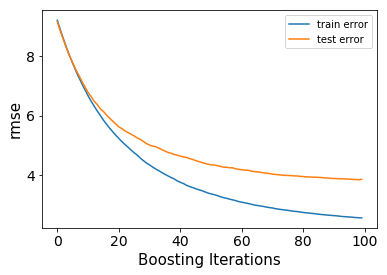

In [30]:
plt.figure()
plt.plot(train_rmse, label='train error')
plt.plot(test_rmse, label='test error')
plt.ylabel('rmse', size=15)
plt.xlabel('Boosting Iterations', size=15);
plt.legend()
print("Final test RMSE: %s" % test_rmse[-1])

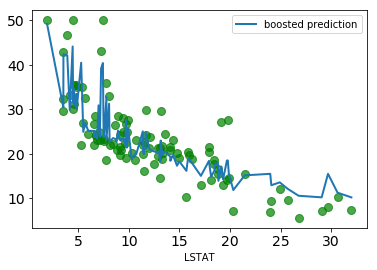

In [31]:
feature = df_test.LSTAT
ix = np.argsort(feature)

# Pick a predictive feature for plotting.
plt.plot(feature, y_test, 'go', alpha=0.7, markersize=8)
plt.plot(feature[ix], test_pred[ix], label='boosted prediction', linewidth=2)

plt.xlabel('LSTAT', size=10)
plt.legend(prop={'size': 10});

In [32]:
list(zip(feature_names, feat_importances))

[('CRIM', 0.08126002689134948),
 ('ZN', 0.0),
 ('INDUS', 0.0),
 ('CHAS', 0.01916181073478576),
 ('NOX', 0.07504686414921595),
 ('RM', 0.250765994388645),
 ('AGE', 0.009487446730683054),
 ('DIS', 0.14890367235577828),
 ('RAD', 0.005626719145003824),
 ('TAX', 0.050511043044339884),
 ('PTRATIO', 0.09595569892026379),
 ('B', 0.030844620830418466),
 ('LSTAT', 0.23243610280951665)]

Copyright 2019 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License